In [1]:
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
coord_pairs = []
with open('data/population_lolland_4500.json') as json_file:
    data = json.load(json_file)
    for person in data['persons']:
        start_coord = person['activities'][0]['coord']
        end_coord = person['activities'][1]['coord']
        time = person['activities'][1]['start_time']
        szone = person['activities'][0]['zone']
        ezone = person['activities'][1]['zone']
        coord_pairs.append((start_coord[0],start_coord[1], end_coord[0], end_coord[1], time, szone, ezone))

In [3]:
outgoing = 0
incomming = 0
within = 0
zone = [360240, 360120, 360210, 360110, 360230, 360130, 360140, 360250]
# sjobo = [360250, 360240, 360230, 360210]
for person in data['persons']:
    szone = int(person['activities'][0]['zone'])
    ezone = int(person['activities'][1]['zone'])
    
    if szone in zone and ezone in zone:
        within += 1
    elif szone in zone and ezone not in zone:
        outgoing += 1
    else:
        incomming += 1

In [4]:
print (outgoing, incomming, within)
print(outgoing + incomming + within)

683 743 3106
4532


In [5]:
import pandas as pd
df = pd.DataFrame(coord_pairs, columns=['slat','slon','elat','elon','time', 'szone','ezone'])
# df['latlon'] = df.lat.astype(str)+df.lon.astype(str)

In [6]:
df.head()

,slat,slon,elat,elon,time,szone,ezone
0,54.767084,11.877373,54.833249,11.138193,00:45:01,376140,360240
1,54.767084,11.877373,54.833249,11.138193,00:34:23,376140,360240
2,54.767084,11.877373,54.833249,11.138193,00:40:47,376140,360240
3,54.767084,11.877373,54.833249,11.138193,00:27:24,376140,360240
4,54.767084,11.877373,54.776641,11.501673,00:33:00,376140,360120


In [7]:
df.iloc[0].time.split(':')[0]+':00'

'00:00'

In [8]:
class OtpMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    TRANSIT = 'TRANSIT,WALK'
    BUS = 'BUS,WALK'
    RAIL = 'TRAM,RAIL,SUBWAY,FUNICULAR,GONDOLA,WALK'
    BICYCLE = 'BICYCLE'
    BICYCLE_TRANSIT = 'TRANSIT,BICYCLE'
    PARK_RIDE = 'CAR_PARK,WALK,TRANSIT'
    KISS_RIDE = 'CAR,WALK,TRANSIT'
    BIKE_RIDE = 'BICYCLE_PARK,WALK,TRANSIT'
    RENTED_BICYCLE = 'WALK,BICYCLE_RENT'
    TRANSIT_RENTED_BICYCLE = 'TRANSIT,WALK,BICYCLE_RENT'
    DRT = 'DRT'
    DRT_TRANSIT = 'DRT_TRANSIT'

    _DICT = ['CAR', 'WALK', 'TRANSIT', 'BUS', 'RAIL', 'BICYCLE', 'BICYCLE_TRANSIT', 'PARK_RIDE', 'KISS_RIDE',
             'BIKE_RIDE', 'RENTED_BICYCLE', 'TRANSIT_RENTED_BICYCLE', 'DRT', 'DRT_TRANSIT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'TRANSIT', 'WALK']

    _DRT_MODES = ['DRT', 'DRT_TRANSIT']

    _PT_MODES = ['TRANSIT', 'BUS', 'RAIL']

    @staticmethod
    def get_all_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._DICT]

    @staticmethod
    def get_main_modes():
        return [OtpMode.__dict__.get(item) for item in OtpMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in OtpMode._DICT

    @staticmethod
    def get_pt_modes():
        return OtpMode._PT_MODES

    @staticmethod
    def get_drt_modes():
        return OtpMode._DRT_MODES

    @staticmethod
    def get_mode(string):
        if OtpMode.contains(string):
            return OtpMode.__getattribute__(OtpMode(), string)
        else:
            raise Exception('unsupported mode {}'.format(string))


In [9]:
class Coord(object):
    """Coordinate.

    Parameters
    ----------
    lat : <float> latitude
    lon : <float> longitude
    latlon : <list> list with both lat and long. Latitude first!
    """
    def __init__(self, lat=None, lon=None, latlon=None):
        if latlon is not None:
            if len(latlon) != 2:
                raise Exception("Wrong coordinate latlon format. Should be a list of two floats.")
            self.lat = latlon[0]
            self.lon = latlon[1]
        elif lat is None or lon is None:
            raise Exception("Coordinates not provided")
        else:
            self.lat = lat
            self.lon = lon

    def to_json(self):
        return json.dumps(self, default=lambda o: self._try(o), sort_keys=True, indent=4, separators=(',', ':'))

    @staticmethod
    def _try(o):
        try:
            if o.__class__ == Coord:
                raise Exception()
            return o.__dict__
        except:
            return str(o)
        
    def __str__(self):
        return str(self.lat) + ',' + str(self.lon)

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return self.lat == other.lat and self.lon == other.lon

    def __hash__(self):
        return hash((self.lat, self.lon))


In [10]:
class Leg(object):
    """Leg of a trip. For example, "walk - bus - walk" trip has three legs.
    Used to store trip legs from OTP.

    Parameters
    ----------
    mode : <str> mode of transport
    start_coord : <coord> coordinate of an origin
    end_coord : <coord> coordinate of a destination
    distance : <int> meters
    duration : <int> seconds
    steps : <list> of utils.Step
    """

    # TODO:assignment of mode   as a string is confusing, remove it, or use constant
    def __init__(self, mode=None, start_coord=None, from_stop=None, end_coord=None, to_stop=None,
                 start_time=None, end_time=None,
                 distance=None, duration=None, steps=None):
        self.mode = mode
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration
        self.steps = steps
        # The two below only used for PT legs
        self.from_stop = from_stop
        self.to_stop = to_stop

        self.start_time = start_time
        self.end_time = end_time

    def deepcopy(self):
        if self.steps is None:
            steps = []
        else:
            steps = [step.deepcopy() for step in self.steps if step is not None]
        return Leg(mode=copy.copy(self.mode),
                   start_coord=copy.copy(self.start_coord),
                   from_stop=copy.copy(self.from_stop),
                   end_coord=copy.copy(self.end_coord),
                   to_stop=copy.copy(self.to_stop),
                   start_time=copy.copy(self.start_time),
                   end_time=copy.copy(self.end_time),
                   distance=copy.copy(self.distance),
                   duration=copy.copy(self.duration),
                   steps=steps)


In [11]:
class Trip(object):
    """A list of legs and a total trip duration
    """
    legs = ...  # type: List[Leg]

    def __init__(self):
        self.legs = []
        self.duration = None
        self.distance = None
        self.main_mode = None

    def set_empty_trip(self, mode, coord_start, coord_end):
        """Sets a dummy trip between two coordinates with zero distance, duration and one empty leg"""
        self.set_duration(0)
        self.set_distance(0)
        self.main_mode = mode
        self.legs = [Leg(mode=mode, start_coord=coord_start, end_coord=coord_end, distance=0, duration=0,
                         steps=[Step(coord_start, coord_end, 0, 0)])]

    def dumps(self):
        return self.__dict__

    def get_leg_modes(self):
        """Returns a list of modes from the legs"""
        return [l.mode for l in self.legs]

    def deepcopy(self):
        nt = Trip()
        nt.duration = copy.copy(self.duration)
        nt.distance = copy.copy(self.distance)
        nt.main_mode = copy.copy(self.main_mode)
        nt.legs = [leg.deepcopy() for leg in self.legs]
        return nt

    def main_mode_from_legs(self):
        leg_modes = self.get_leg_modes()

        if LegMode.CAR in leg_modes:
            return OtpMode.CAR
        elif LegMode.BUS in leg_modes or LegMode.SUBWAY in leg_modes or \
                LegMode.TRAM in leg_modes or LegMode.RAIL in leg_modes:
            return OtpMode.TRANSIT
        elif LegMode.BICYCLE in leg_modes:
            return OtpMode.BICYCLE
        elif LegMode.WALK in leg_modes:
            return OtpMode.BICYCLE
        else:
            log.error('Main mode unrecognized. Returning None. Kick the developer to make a proper function.')
            return None

    def set_duration(self, dur):
        self.duration = dur

    def set_main_mode(self, mode):
        self.main_mode = mode
    
    def set_distance(self, dist):
        self.distance = dist
    
    def append_leg(self, leg):
        self.legs.append(leg)
        
    def __str__(self):
        return '{} trip, takes {} distance {}'\
            .format(self.main_mode, self.duration, self.distance)

    def __repr__(self):
        return str(self)


In [12]:
class LegMode(object):
    CAR = 'CAR'
    WALK = 'WALK'
    BUS = 'BUS'
    RAIL = 'RAIL'
    BICYCLE = 'BICYCLE'
    TRAM = 'TRAM'
    SUBWAY = 'SUBWAY'
    CAR_PARK = 'CAR_PARK'
    BICYCLE_PARK = 'BICYCLE_PARK'
    BICYCLE_RENT = 'BICYCLE_RENT'
    DRT = 'DRT'

    _DICT = ['CAR', 'WALK', 'BUS', 'RAIL', 'BICYCLE', 'TRAM', 'SUBWAY',
             'CAR_PARK', 'BICYCLE_PARK', 'BICYCLE_RENT', 'DRT']

    _MAIN_MODES = ['CAR', 'BICYCLE', 'BUS', 'RAIL', 'WALK']

    @staticmethod
    def get_all_modes():
        return [LegMode.__dict__.get(item) for item in LegMode._DICT]

    @staticmethod
    def get_main_modes():
        return [LegMode.__dict__.get(item) for item in LegMode._MAIN_MODES]

    @staticmethod
    def contains(other):
        return other in LegMode._DICT

    @staticmethod
    def get_mode(string):
        if LegMode.contains(string):
            return LegMode
        else:
            raise Exception('unsupported mode {}'.format(string))

In [13]:
class Step(object):
    """Arguments:|
    start_coord       <Coord>|
    distance    <int>|
    duration    <int>|
    """
    def __init__(self, start_coord, end_coord, distance, duration):
        self.start_coord = start_coord
        self.end_coord = end_coord
        self.distance = distance
        self.duration = duration

    @staticmethod
    def get_empty_step(coord):
        return Step(start_coord=coord, end_coord=coord, distance=0, duration=0)

    def deepcopy(self):
        return Step(start_coord=copy.copy(self.start_coord),
                    end_coord=copy.copy(self.end_coord),
                    distance=copy.copy(self.distance),
                    duration=copy.copy(self.duration),
                    )

    def dumps(self):
        return self.__dict__

    def __str__(self):
        return 'Step distance {:.1f}, duration {:.1f}'.format(self.distance, self.duration)

    def __repr__(self):
        return self.__str__()


In [14]:
def parse_otp_response(resp):
    if resp.status_code != requests.codes.ok:
        resp.raise_for_status()

    jresp = resp.json()
    if 'error' in jresp.keys():
        if jresp.get('error').get('id') == 409:
            raise Exception()
        elif jresp.get('error').get('id') == 404:
            raise Exception()
        else:
            raise Exception()

    itineraries = jresp.get('plan').get('itineraries')

    trips = []
    geometries = []
    for itinerary in itineraries:
        trip = Trip()
        trip.set_duration(itinerary.get('duration'))
        trip.set_distance(sum([leg.get('distance') for leg in itinerary.get('legs')]))
        geometry = []
        for raw_leg in itinerary.get('legs'):            
            leg = Leg()
            leg.distance = raw_leg.get('distance')
            leg.duration = raw_leg.get('duration')
            raw_from = raw_leg.get('from')
            leg.start_coord = Coord(lat=raw_from.get('lat'),
                                    lon=raw_from.get('lon'))
            raw_to = raw_leg.get('to')
            leg.end_coord = Coord(lat=raw_to.get('lat'),
                                  lon=raw_to.get('lon'))
            leg.mode = raw_leg.get('mode')
#             leg.steps = [self.step_from_raw(s) for s in raw_leg.get('steps')]

#              leg.start_time = int(raw_leg.get('startTime'))/1000 - self.env.config.get('date.unix_epoch')
#              leg.end_time = int(raw_leg.get('endTime'))/1000 - self.env.config.get('date.unix_epoch')

            if leg.mode in OtpMode.get_pt_modes():
                # OTP has id in the following format: 'SE-st:9022012065015001'
                # we are not interested in the first part
                leg.from_stop = int(raw_from.get('stopId').split(':')[1])
                leg.to_stop = int(raw_to.get('stopId').split(':')[1])
            trip.append_leg(leg)

            trip.main_mode = trip.main_mode_from_legs()       
            geometry.append(raw_leg.get('legGeometry').get('points'))
        geometries.append(geometry)
        trips.append(trip)
#         to return only one
#         break

    return trips, geometries

def otp_request( from_place,
                 to_place,
                 at_time,
                 mode: str,
                 attributes=None):
    default_attributes = {'fromPlace': str(from_place),
                          'toPlace': str(to_place),
                          'date': '11-17-2020',
                          'mode': mode,
                          'arriveBy': 'False',
                          'maxWalkDistance': 2000,
                          'time': at_time,
                          'maxTransfers': 10,
                          'numItineraries': 5
                         }
    if attributes is not None:
        default_attributes.update(attributes)
    
    try:
        resp = requests.get('http://localhost:8080/otp/routers/lolland/plan', params=default_attributes)
    
        # payload = Payload(attributes=default_attributes, config=self.env.config)

        # resp = requests.get(self.url, params=payload.get_payload())
        
        parsed_trips, geometries = parse_otp_response(resp)
    except Exception as e:
        print('otp exception!')
        print(default_attributes)
        print(e)
        return [None], [None]

    for trip in parsed_trips:
        trip.set_main_mode(mode)

    return parsed_trips, geometries

In [15]:
df['szone']=df.szone.astype(int)
df['ezone']=df.ezone.astype(int)

In [16]:
def choose(alternatives):
    filtered_alternatives = []
    for trip in alternatives:
        trip.utility = self.calc_utility(trip)
        filtered_alternatives.append(trip)

    if len(filtered_alternatives) != 0:
        mnl(filtered_alternatives)
        return montecarlo(filtered_alternatives)
    else:
        return None
    
def calc_utility(trip):
    """Pretty much random numbers so far
    TODO: make a model class to be added to config
    """
    vot = {LegMode.CAR: 0.023/60,
           LegMode.BUS: 0.023/60,
           LegMode.RAIL: 0.023/60,
           LegMode.TRAM: 0.023/60,
           LegMode.WALK: 0.032/60,
#            LegMode.BICYCLE: 0.0007,
#            LegMode.SUBWAY: 0.005,
#            LegMode.BICYCLE_RENT: 0.004,
           LegMode.DRT: 0.023/60
           }
    c = 0.074/60
    try:
        if len(trip.legs) > 0:
            s = sum([leg.duration*vot.get(leg.mode) for leg in trip.legs])
            if trip.main_mode == LegMode.CAR:
                car_dist = [leg.distance for leg in trip.legs if leg.mode == LegMode.CAR]
                cost = sum([d*2.79 for d in car_dist])
            else:
                cost = 51
            s += c*cost
        else:
            print('am I ever here?')
            s = trip.duration*vot.get(trip.main_mode)
    except RuntimeError:
        print([leg.mode for leg in trip.legs])
        raise Exception('wrong math in MNL')
    return s

def mnl(alternatives):
    s = sum([math.exp(trip.utility) for trip in alternatives])
    for trip in alternatives:
        trip.prob = math.exp(trip.utility) / s
        
def montecarlo(self, alternatives):
    # use numpy random choice
    if sum([trip.prob for trip in alternatives]) < 0.99999998:
        print(alternatives)
        raise Exception('Probability is not 1, but {}'.format(sum([trip.prob for trip in alternatives])))
    r = self.env.rand.uniform(0, 1)
    c = 0.0

    for a in alternatives:
        if a.main_mode in OtpMode.get_drt_modes():
            return a
    for a in alternatives:
        if a.main_mode == OtpMode.CAR:
            return a

    for trip in alternatives:
        c += trip.prob
        if c > r:
            return trip
    raise Exception('Montecarlo failed')

In [18]:
trips = []
persons = []

persons_to_remove = []

for (_,trip), person in zip(df.iterrows(), data['persons']):
        
    print(_)
    
    print('time {}'.format(trip.time))
    
    # only take an hour, as OTP does not return earlier trips
    trip_time = trip.time.split(":")[0]+":00"
        
    trip_pt, pol_pt = otp_request(from_place='{},{}'.format(trip.slat,trip.slon),
                            to_place='{},{}'.format(trip.elat,trip.elon),
                            at_time = trip_time, mode = 'TRANSIT,WALK')
    
    trip_car, pol_car = otp_request(from_place='{},{}'.format(trip.slat,trip.slon),
                            to_place='{},{}'.format(trip.elat,trip.elon),
                            at_time = trip_time, mode = 'CAR')
    
    if pol_car[0] is None or pol_pt[0] is None:
        persons_to_remove.append(person)
        continue
    
    trip_pt, pol_pt = min(zip(trip_pt, pol_pt), key=lambda x: x[0].duration)
    trip_car, pol_car = min(zip(trip_car, pol_car), key=lambda x: x[0].duration)    
        
    trips.append((trip_pt,trip_car))
    persons.append(person)

0
time 00:45:01
1
time 00:34:23
2
time 00:40:47
3
time 00:27:24
4
time 00:33:00
5
time 04:57:39
6
time 04:48:01
7
time 04:41:45
8
time 04:48:04
9
time 04:30:02
10
time 04:11:45
11
time 04:54:56
12
time 04:28:18
13
time 05:39:28
14
time 05:15:09
15
time 05:01:58
16
time 05:15:41
17
time 05:40:44
18
time 05:16:26
19
time 05:31:28
20
time 05:58:13
21
time 05:05:57
22
time 05:43:08
23
time 05:57:50
24
time 05:18:31
25
time 05:29:36
26
time 05:13:57
27
time 05:05:21
28
time 05:04:42
29
time 05:56:21
30
time 05:34:32
31
time 05:59:17
32
time 05:26:32
33
time 05:29:08
34
time 05:09:49
35
time 05:23:49
36
time 05:58:13
37
time 05:45:29
38
time 05:30:55
39
time 05:43:35
40
time 05:46:59
41
time 05:47:58
42
time 05:57:16
43
time 05:01:48
44
time 05:34:44
45
time 05:31:59
46
time 05:44:32
47
time 05:51:56
48
time 05:24:02
49
time 05:15:12
50
time 05:36:48
51
time 05:01:31
52
time 05:39:40
53
time 05:05:19
54
time 05:59:53
55
time 05:00:01
56
time 05:20:25
57
time 05:14:40
58
time 05:38:57
59
time

462
time 07:11:16
463
time 07:39:49
464
time 07:11:43
465
time 07:04:28
466
time 07:00:18
467
time 07:06:50
468
time 07:30:08
469
time 07:51:00
470
time 07:58:13
471
time 07:47:49
472
time 07:32:22
473
time 07:01:59
474
time 07:26:48
475
time 07:01:27
476
time 07:01:56
477
time 07:31:20
478
time 07:11:53
479
time 07:51:34
480
time 07:51:14
481
time 07:04:19
482
time 07:00:22
483
time 07:10:08
484
time 07:31:40
485
time 07:13:17
486
time 07:04:18
487
time 07:44:03
488
time 07:50:51
489
time 07:58:46
490
time 07:43:50
491
time 07:14:11
492
time 07:08:03
493
time 07:02:50
494
time 07:21:38
495
time 07:12:58
496
time 07:00:26
497
time 07:04:14
498
time 07:08:38
499
time 07:50:05
500
time 07:29:15
501
time 07:18:56
502
time 07:19:11
503
time 07:46:25
504
time 07:56:14
505
time 07:15:24
506
time 07:55:32
507
time 07:27:32
508
time 07:52:35
509
time 07:31:23
510
time 07:42:51
511
time 07:56:51
512
time 07:22:57
513
time 07:47:31
514
time 07:55:43
515
time 07:44:19
516
time 07:30:18
517
time 0

921
time 07:37:27
922
time 07:49:38
923
time 07:01:14
924
time 07:22:50
925
time 07:11:56
926
time 07:01:18
927
time 07:18:52
928
time 07:49:39
929
time 07:33:00
930
time 07:36:50
931
time 07:53:05
932
time 07:16:07
933
time 07:26:24
934
time 07:48:29
935
time 07:01:47
936
time 07:53:47
937
time 07:43:56
938
time 07:54:58
939
time 07:13:38
940
time 07:03:40
941
time 07:22:53
942
time 07:50:25
943
time 07:27:21
944
time 07:59:22
945
time 07:12:04
946
time 07:57:03
947
time 07:13:11
948
time 07:33:46
949
time 07:47:14
950
time 07:46:00
951
time 07:16:05
952
time 07:58:09
953
time 07:37:07
954
time 07:50:44
955
time 07:03:45
956
time 07:48:31
957
time 07:13:32
958
time 07:40:14
959
time 07:56:01
960
time 07:01:54
961
time 07:43:30
962
time 07:04:58
963
time 07:33:13
964
time 07:51:01
965
time 07:56:35
966
time 07:25:31
967
time 07:13:11
968
time 07:15:57
969
time 07:10:15
970
time 07:22:10
971
time 07:42:14
972
time 07:11:58
973
time 07:43:42
974
time 07:14:10
975
time 07:57:08
976
time 0

1358
time 09:41:37
1359
time 09:45:05
1360
time 09:24:53
1361
time 09:47:28
1362
time 09:37:04
1363
time 09:35:31
1364
time 09:25:39
1365
time 09:32:29
1366
time 09:21:28
1367
time 09:40:29
1368
time 09:44:22
1369
time 09:24:32
1370
time 09:50:36
1371
time 09:01:51
1372
time 09:51:55
1373
time 09:42:43
1374
time 09:43:25
1375
time 09:02:07
1376
time 09:16:42
1377
time 09:52:02
1378
time 09:07:52
1379
time 09:39:31
1380
time 09:05:17
1381
time 09:55:48
1382
time 09:09:58
1383
time 09:32:38
1384
time 09:16:15
1385
time 09:37:26
1386
time 09:51:10
1387
time 09:21:02
1388
time 09:05:31
1389
time 09:31:49
1390
time 09:49:16
1391
time 09:33:48
1392
time 09:06:09
1393
time 09:14:07
1394
time 09:05:17
1395
time 09:35:41
1396
time 09:08:50
1397
time 09:00:59
1398
time 09:52:16
1399
time 09:00:43
1400
time 09:02:47
1401
time 09:32:57
1402
time 09:08:07
1403
time 09:35:09
1404
time 09:23:51
1405
time 09:16:51
1406
time 09:57:29
1407
time 09:14:54
1408
time 09:47:35
1409
time 09:32:45
1410
time 09

1790
time 11:34:57
1791
time 11:46:33
1792
time 11:24:10
1793
time 11:23:40
1794
time 11:19:07
1795
time 11:04:53
1796
time 11:41:11
1797
time 11:38:26
1798
time 11:30:31
1799
time 11:37:22
1800
time 11:14:51
1801
time 11:07:15
1802
time 11:04:07
1803
time 11:22:36
1804
time 11:46:06
1805
time 11:38:08
1806
time 11:29:07
1807
time 11:28:55
1808
time 11:46:26
1809
time 11:34:59
1810
time 11:40:11
1811
time 11:38:21
1812
time 11:11:17
1813
time 11:40:18
1814
time 11:53:13
1815
time 11:54:27
1816
time 11:22:21
1817
time 11:54:26
1818
time 11:41:30
1819
time 11:33:44
1820
time 11:59:48
1821
time 11:53:59
1822
time 11:05:13
1823
time 11:21:47
1824
time 11:51:03
1825
time 11:01:56
1826
time 11:15:48
1827
time 11:56:12
1828
time 11:03:36
1829
time 11:56:28
1830
time 11:23:34
1831
time 11:00:14
1832
time 11:23:40
1833
time 11:04:07
1834
time 11:54:25
1835
time 11:30:41
1836
time 11:32:10
1837
time 11:56:48
1838
time 11:51:25
1839
time 11:18:52
1840
time 11:17:13
1841
time 11:18:15
1842
time 11

2223
time 12:32:18
2224
time 12:35:59
2225
time 12:50:54
2226
time 12:05:38
2227
time 12:54:43
2228
time 12:28:46
2229
time 12:15:59
2230
time 12:23:23
2231
time 12:12:14
2232
time 12:32:09
2233
time 12:49:18
2234
time 12:38:39
2235
time 12:25:42
2236
time 12:04:57
2237
time 12:19:15
2238
time 12:37:08
2239
time 12:45:23
2240
time 12:28:43
2241
time 12:30:15
2242
time 12:00:39
2243
time 12:18:29
2244
time 12:32:12
2245
time 12:08:50
2246
time 12:46:55
2247
time 12:59:05
2248
time 12:18:34
2249
time 12:39:01
2250
time 12:47:32
2251
time 12:14:45
2252
time 12:58:23
2253
time 12:00:38
2254
time 12:18:32
2255
time 12:47:44
2256
time 12:43:50
2257
time 12:39:39
2258
time 12:24:08
2259
time 12:43:24
2260
time 12:55:13
2261
time 12:22:58
2262
time 12:28:10
2263
time 12:39:55
2264
time 12:36:22
2265
time 12:48:40
2266
time 12:29:17
2267
time 12:43:02
2268
time 12:45:29
2269
time 12:29:18
2270
time 12:32:59
2271
time 12:32:09
2272
time 12:34:59
2273
time 12:46:01
2274
time 12:36:19
2275
time 12

2658
time 13:14:07
2659
time 13:18:38
2660
time 13:08:53
2661
time 13:43:13
2662
time 13:10:15
2663
time 13:58:21
2664
time 13:20:12
2665
time 13:08:22
2666
time 13:58:20
2667
time 13:57:49
2668
time 13:06:07
2669
time 13:24:41
2670
time 13:38:41
2671
time 13:19:43
2672
time 13:44:53
2673
time 13:26:47
2674
time 13:07:01
2675
time 13:32:17
2676
time 13:09:37
2677
time 13:47:36
2678
time 13:42:25
2679
time 13:51:14
2680
time 13:10:52
2681
time 13:35:03
2682
time 13:55:56
2683
time 13:32:08
2684
time 13:34:20
2685
time 13:53:01
2686
time 13:12:56
2687
time 13:01:38
2688
time 13:11:58
2689
time 13:45:36
2690
time 13:27:09
2691
time 13:35:06
2692
time 13:45:51
2693
time 13:52:35
2694
time 13:54:27
2695
time 13:53:29
2696
time 13:11:26
2697
time 13:57:04
2698
time 13:11:29
2699
time 13:01:54
2700
time 13:24:16
2701
time 13:59:13
2702
time 13:43:18
2703
time 13:44:09
2704
time 13:40:13
2705
time 13:40:36
2706
time 13:43:18
2707
time 13:03:19
2708
time 13:51:39
2709
time 13:22:32
2710
time 13

3091
time 14:18:46
3092
time 14:06:02
3093
time 14:23:47
3094
time 14:00:05
3095
time 14:29:05
3096
time 14:54:44
3097
time 14:57:55
3098
time 14:42:01
3099
time 14:38:15
3100
time 14:55:09
3101
time 14:10:02
3102
time 14:40:50
3103
time 14:08:17
3104
time 14:05:44
3105
time 14:33:19
3106
time 14:25:26
3107
time 14:23:57
3108
time 14:27:34
3109
time 14:09:38
3110
time 14:19:35
3111
time 14:38:33
3112
time 14:33:58
3113
time 14:50:56
3114
time 14:34:36
3115
time 14:43:44
3116
time 14:56:08
3117
time 14:43:27
3118
time 14:22:56
3119
time 14:12:46
3120
time 14:30:08
3121
time 14:30:36
3122
time 14:37:51
3123
time 14:46:00
3124
time 14:07:25
3125
time 14:22:02
3126
time 14:38:24
3127
time 14:29:02
3128
time 14:48:35
3129
time 14:31:57
3130
time 14:08:16
3131
time 14:46:45
3132
time 14:45:34
3133
time 14:02:09
3134
time 14:14:00
3135
time 14:45:20
3136
time 14:02:03
3137
time 14:25:18
3138
time 14:19:34
3139
time 14:02:02
3140
time 14:38:30
3141
time 14:52:36
3142
time 14:31:03
3143
time 14

3510
time 15:39:42
3511
time 15:07:26
3512
time 15:51:09
3513
time 15:31:43
3514
time 15:45:57
3515
time 15:02:51
3516
time 15:15:09
3517
time 15:15:30
3518
time 15:54:25
3519
time 15:00:35
3520
time 15:34:14
3521
time 15:19:08
3522
time 15:04:43
3523
time 15:42:29
3524
time 15:58:32
3525
time 15:33:20
3526
time 15:22:04
3527
time 15:58:43
3528
time 15:15:54
3529
time 15:08:21
3530
time 15:50:42
3531
time 15:50:36
3532
time 15:53:01
3533
time 15:22:11
3534
time 15:40:24
3535
time 15:04:58
3536
time 15:29:22
3537
time 15:03:34
3538
time 15:33:03
3539
time 15:53:14
3540
time 15:33:26
3541
time 15:33:15
3542
time 15:19:04
3543
time 15:10:02
3544
time 15:53:57
3545
time 15:15:10
3546
time 15:36:52
3547
time 15:01:01
3548
time 15:07:40
3549
time 15:24:22
3550
time 15:16:05
3551
time 15:08:03
3552
time 15:39:08
3553
time 15:29:11
3554
time 15:23:33
3555
time 15:41:40
3556
time 15:33:27
3557
time 15:29:47
3558
time 15:12:32
3559
time 15:46:06
3560
time 15:45:01
3561
time 15:10:42
3562
time 15

3942
time 16:05:27
3943
time 16:52:02
3944
time 16:13:18
3945
time 16:43:02
3946
time 16:41:53
3947
time 16:31:37
3948
time 16:02:20
3949
time 16:37:31
3950
time 16:05:36
3951
time 16:55:59
3952
time 16:39:51
3953
time 16:03:10
3954
time 16:34:50
3955
time 16:45:25
3956
time 16:30:38
3957
time 16:40:16
3958
time 16:09:55
3959
time 16:19:09
3960
time 16:21:21
3961
time 16:11:56
3962
time 16:50:30
3963
time 16:57:49
3964
time 16:49:03
3965
time 16:34:14
3966
time 16:36:26
3967
time 16:04:45
3968
time 16:55:44
3969
time 16:05:57
3970
time 16:11:12
3971
time 16:34:50
3972
time 16:24:17
3973
time 16:28:21
3974
time 16:10:10
3975
time 16:44:47
3976
time 16:54:52
3977
time 16:28:23
3978
time 16:40:03
3979
time 16:18:20
3980
time 16:23:34
3981
time 16:52:25
3982
time 16:12:32
3983
time 16:29:54
3984
time 16:43:55
3985
time 16:52:15
3986
time 16:53:32
3987
time 16:12:53
3988
time 16:31:47
3989
time 16:40:04
3990
time 16:07:02
3991
time 16:54:01
3992
time 16:29:07
3993
time 16:14:49
3994
time 16

4376
time 19:11:51
4377
time 19:41:41
4378
time 19:09:37
4379
time 19:24:52
4380
time 19:22:44
4381
time 19:28:23
4382
time 19:31:04
4383
time 19:23:07
4384
time 19:18:57
4385
time 19:56:37
4386
time 19:22:23
4387
time 19:20:27
4388
time 19:07:15
4389
time 19:48:38
4390
time 19:36:57
4391
time 19:28:06
4392
time 19:34:47
4393
time 19:05:40
4394
time 19:37:20
4395
time 19:03:51
4396
time 19:50:57
4397
time 19:19:55
4398
time 19:05:15
4399
time 19:05:41
4400
time 19:02:54
4401
time 19:51:04
4402
time 19:09:44
4403
time 19:44:23
4404
time 19:07:14
4405
time 19:57:11
4406
time 19:26:28
4407
time 19:53:38
4408
time 19:35:54
4409
time 19:44:49
4410
time 19:31:51
4411
time 19:15:33
4412
time 19:12:21
4413
time 19:37:38
4414
time 19:54:00
4415
time 19:33:21
4416
time 19:45:28
4417
time 19:47:43
4418
time 19:33:32
4419
time 19:23:28
4420
time 19:01:16
4421
time 19:24:44
4422
time 20:47:25
4423
time 20:57:47
4424
time 20:20:42
4425
time 20:10:48
4426
time 20:44:12
4427
time 20:20:39
4428
time 20

In [19]:
trip_pt

TRANSIT,WALK trip, takes 1140 distance 19551.763377313662

In [20]:
print('persons_to_remove', len(persons_to_remove))
print('trips', len(trips))
print('persons', len(persons))

persons_to_remove 1
trips 4531
persons 4531


In [21]:
len(persons_to_remove)+len(persons)

4532

# Recalculate number of people within PT time windows
# and within walkable distane

In [22]:
trips_all_outside = []
persons_all_outside = []

trips_all_inside = []
persons_all_inside = []

for trip, person in zip(trips, persons):
    szone = int(person['activities'][0]['zone'])
    ezone = int(person['activities'][1]['zone'])
    if szone in zone and ezone in zone:
        trips_all_inside.append(trip)
        persons_all_inside.append(person)
    else:
        trips_all_outside.append(trip)
        persons_all_outside.append(person)
        
print('Outside ', len(trips_all_outside))
print('Inside ', len(trips_all_inside))
print('All ', len(trips_all_outside) + len(trips_all_inside))

Outside  1426
Inside  3105
All  4531


In [33]:
def trips_from_time_ratio(trips_all_outside,persons_all_outside,threshold):
    n = 0
    for tr, person in zip(trips_all_outside, persons_all_outside):
        if tr[0] is None:
            continue
        
        try:
            trip_pt = tr[0]
            trip_car = tr[1]
            
            if trip_pt.duration < trip_car.duration * threshold:
                n += 1
        except:
            print(tr)
        
        
    return n

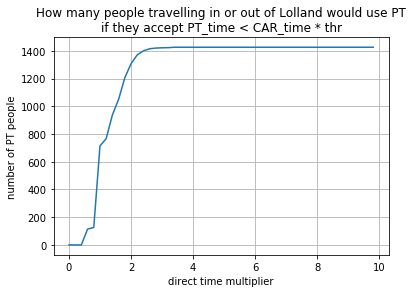

In [39]:
step = np.arange(0, 10, 0.2)
y = [trips_from_time_ratio(trips_all_outside, persons_all_outside, x) for x in step]
fig, ax = plt.subplots()
ax.plot(step, y)
ax.set(xlabel='direct time multiplier', ylabel='number of PT people',
       title='How many people travelling in or out of Lolland would use PT\nif they accept PT_time < CAR_time * thr')
ax.grid()
fig.savefig('data/distr.png', dpi=600)

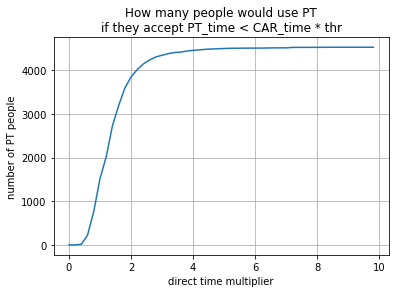

In [40]:
step = np.arange(0, 10, 0.2)
y = [trips_from_time_ratio(trips, persons, x) for x in step]
fig, ax = plt.subplots()
ax.plot(step, y)
ax.set(xlabel='direct time multiplier', ylabel='number of PT people',
       title='How many people would use PT\nif they accept PT_time < CAR_time * thr')
ax.grid()
fig.savefig('data/distr.png', dpi=600)

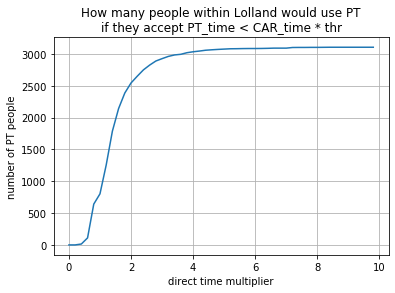

In [36]:
step = np.arange(0, 10, 0.2)
y = [trips_from_time_ratio(trips_all_inside, persons_all_inside, x) for x in step]
fig, ax = plt.subplots()
ax.plot(step, y)
ax.set(xlabel='direct time multiplier', ylabel='number of PT people',
       title='How many people within Lolland would use PT\nif they accept PT_time < CAR_time * thr')
ax.grid()

# With this we can calibrate time window size

In [ ]:
def trips_from_time_ratio_in_out(trips_all_outside,persons_all_outside,threshold, in_zone=True):
    n = 0
    for tr, person in zip(trips_all_outside, persons_all_outside):
        if tr[0] is None:
            continue
            
        trip_pt = tr[0][0]
        trip_car = tr[1][0]
        
        szone = int(person['activities'][0]['zone'])
        if szone in zone and in_zone == True:
            continue
        elif szone not in zone and in_zone == False:
            continue
        
        if trip_pt.duration <= trip_car.duration * threshold:
            n += 1
    return n

In [ ]:
pt_in = [trips_from_time_ratio_in_out(trips_all_outside, persons_all_outside, x, in_zone=True) for x in np.arange(0, 10, 0.05)]
pt_out = [trips_from_time_ratio_in_out(trips_all_outside, persons_all_outside, x, in_zone=False) for x in np.arange(0, 10, 0.05)]
print('in', pt_in)
print('out', pt_out)

In [ ]:
print(pt_in[31], np.arange(0, 10, 0.05)[31])
print(pt_out[39], np.arange(0, 10, 0.05)[39])

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, 10, 0.05), pt_in)
ax.set(xlabel='multiplier coefficient', ylabel='number of drtable people',
       title='Number of people with a PT trip duration < direct time * coefficient')
ax.grid()

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(0, 10, 0.05), pt_out)
ax.set(xlabel='multiplier coefficient', ylabel='number of drtable people',
       title='Number of people with a PT trip duration < direct time * coefficient')
ax.grid()

# Redistribute people according to calibrated time windows

In [ ]:
def trips_from_time_ratio(trips_all, persons_all, walk_threshold, time_coefficient, trip_in):
    pt_persons = []
    other_persons = []
    drtable_persons = []
    for tr, person in zip(trips_all, persons_all):
        
        szone = int(person['activities'][0]['zone'])
        if szone in sjobo and trip_in:
            continue
        elif szone not in sjobo and not trip_in:
            continue
        
        if tr[0] is None:
            other_persons.append(person)
            continue
        
        trip_pt = tr[0][0]
        trip_car = tr[1][0]
        
        if trip_pt.duration <= trip_car.duration * time_coefficient:
            pt_persons.append(person)
        else:
            if szone in sjobo:
                leg_dist = trip_pt.legs[-1].distance
            else:
                leg_dist = trip_pt.legs[0].distance

            if leg_dist <= walk_threshold:
                drtable_persons.append(person)
            else:
                other_persons.append(person)
    
    return pt_persons, drtable_persons, other_persons

In [ ]:
pt_persons_in, drtable_persons_in, other_persons_in = \
trips_from_time_ratio(trips_all_outside, persons_all_outside, 1000, 1.55, trip_in=True)
print(len(pt_persons_in), len(drtable_persons_in), len(other_persons_in))

In [ ]:
pt_persons_out, drtable_persons_out, other_persons_out = \
trips_from_time_ratio(trips_all_outside, persons_all_outside, 1000, 1.95, trip_in=False)
print(len(pt_persons_out), len(drtable_persons_out), len(other_persons_out))

In [ ]:
print('population_within_pt', len(pt_persons_within))
print('population_within_other', len(other_persons_within))
              
print('population_in_pt', len(pt_persons_in))
print('population_out_pt', len(pt_persons_out))
              
print('population_in_drtable', len(drtable_persons_in))
print('population_out_drtable', len(drtable_persons_out))
              
print('population_in_other', len(other_persons_in))
print('population_out_other', len(other_persons_out))

In [ ]:
population = {'population_within_pt': pt_persons_within, 
              'population_within_other': other_persons_within,
              
              'population_in_pt': pt_persons_in,
              'population_out_pt': pt_persons_out,
              
              'population_in_drtable': drtable_persons_in,
              'population_out_drtable': drtable_persons_out,
              
              'population_in_other': other_persons_in,
              'population_out_other': other_persons_out
             }

In [ ]:
with open('data/.json', 'w') as outfile:
    json.dump(population, outfile)